# Follow this notebook from librosa:

* https://librosa.org/librosa_gallery/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py

### Imports

* numpy for basic functionality
* scipy for graph Laplacian
* matplotlib for visualization
* sklearn.cluster for K-Means

In [1]:
import matplotlib.pyplot as plt
import librosa.display

In [2]:
from __future__ import print_function

import numpy as np
import scipy

import sklearn.cluster
import librosa


### Utility functions

In [3]:
def symmetrize_matrix(Rf):
  """
  Symmetrizes a square matrix Rf by averaging its off-diagonal elements.

  Args:
    Rf (numpy.ndarray): The input square matrix.

  Returns:
    numpy.ndarray: A symmetric version of the input matrix.
  """
  # Get the dimensions of the input matrix
  n_rows, n_cols = Rf.shape

  # Ensure the matrix is square
  if n_rows != n_cols:
    raise ValueError("Input matrix must be square for symmetrization.")

  # Create a new array to store the symmetric matrix
  Rf_symmetric = np.zeros_like(Rf, dtype=Rf.dtype)

  # Iterate through the upper triangle of the matrix (including the diagonal)
  for i in range(n_rows):
    for j in range(i, n_cols):
      # Calculate the average of Rf[i, j] and Rf[j, i]
      average_value = (Rf[i, j] + Rf[j, i]) / 2

      # Set both Rf_symmetric[i, j] and Rf_symmetric[j, i] to the average
      Rf_symmetric[i, j] = average_value
      Rf_symmetric[j, i] = average_value

  return Rf_symmetric


In [4]:
def check_matrix(matrix):
    print(f"matrix dtype: {matrix.dtype}")
    print(f"matrix shape: {matrix.shape}")
    
    if np.allclose(matrix, matrix.T.conj()):
        # Matrix L IS Hermitian (within the tolerance of np.allclose)
        print("Matrix is Hermitian")
    else:
        # Matrix L is NOT Hermitian (within the tolerance of np.allclose)
        print("Matrix is NOT Hermitian")
    if np.isnan(matrix).any():
        print("Matrix contains NaN values.")
    if np.isinf(matrix).any():
        print("Matrix contains infinity values.")
    for row in matrix:
        for element in row:
            if element is None:
                print("Matrix contains None values.")
                return

### Load in a song

In [5]:
filename = 'bruno.mp3'

In [26]:
# to use MADMOM for beat detection, process everyting at sampling rate of 44,100 Hz
y, sr = librosa.load(filename, sr=44100)
print(f"Load {filename} into array of len {len(y)} using sample rate {sr}")

Load bruno.mp3 into array of len 9811055 using sample rate 44100


### Compute and plot log-powered CQT

/tmp/ipykernel_787/2169818445.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr,


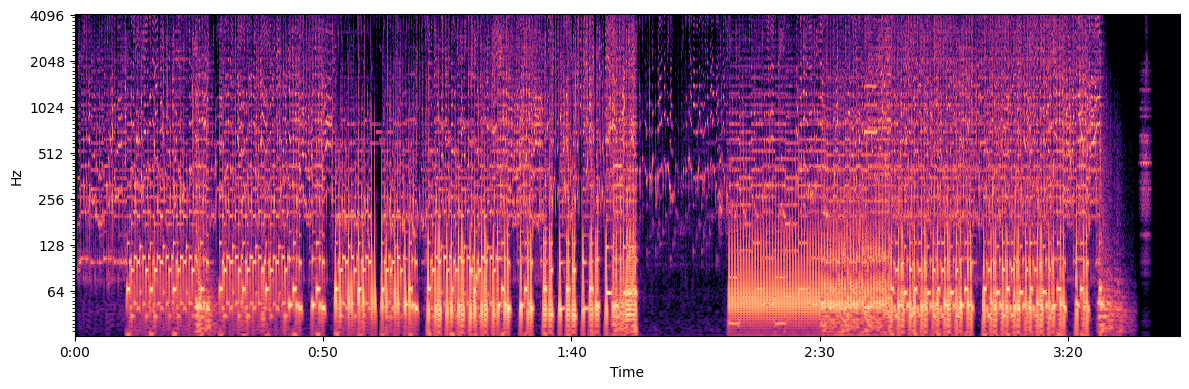

In [7]:
BINS_PER_OCTAVE = 12 * 3
N_OCTAVES = 7
C = librosa.amplitude_to_db(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE),
                                        ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr,
                         bins_per_octave=BINS_PER_OCTAVE,
                         x_axis='time')
plt.tight_layout()

In [8]:
C.shape

(252, 19163)

### Find downbeats via MADMOM

In [ ]:
tempo, lib_beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
lib_beats.shape

(372,)

In [ ]:
proc = madmom.features.DBNDownBeatTrackingProcessor(beats_per_bar=[3, 4], fps=100)
act = madmom.features.RNNDownBeatProcessor()(y)
downbeats = proc(act)
downbeats.shape

(370, 2)

In [34]:
import madmom

def get_beats(filename, y):
    beats_cache_filename = filename + '.npy'
    downbeats = []
    cached_beats = np.array([])

    try:
        cached_beats = np.load(beats_cache_filename)
    except FileNotFoundError:
        print(f"No beats cache file found: '{beats_cache_filename}'")
        cached_beats = np.array([])
    except Exception as e:
        print(f"Warning: An error occurred while opening the file '{beats_cache_filename}': {e}")
        cached_beats = np.array([])


    # if we didn't pass in a beat cache then we'll need to do downbeat
    # detection via madmom
    if cached_beats.size == 0:

        print("Running a high precision beat finding algorithm. This could take up to 2 minutes...")
        proc = madmom.features.DBNDownBeatTrackingProcessor(beats_per_bar=[3, 4], fps=100)
        act = madmom.features.RNNDownBeatProcessor()(y)
        downbeats = proc(act)

        # write downbeat cache
        np.save(beats_cache_filename, downbeats)

    else:
        # the rest of this code expects downbeats to be a 2d numpy array of
        # [beat_time_in_sec, bar_position]
        print("Loading beats from cached numpy array of length: ", len(cached_beats))
        downbeats = cached_beats

 
    # convert MADOM beat timestamps back to frame indices
    btz = librosa.time_to_frames(downbeats[:,0], sr=sr)

    return btz

In [35]:
# tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)

beats = get_beats(filename, y)
tempo = librosa.feature.tempo(y=y, sr=sr)

Loading beats from cached numpy array of length:  370


In [36]:
beats.shape

(370,)

### Compute beat-synchronous CQT to reduce dimentionality

In [43]:
# For plotting purposes, we'll need the timing of the beats
# we fix_frames to include non-beat frames 0 and C.shape[1] (final frame)
beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats,
                                                            x_min=0,
                                                            x_max=C.shape[1]),
                                                            sr=sr)


In [44]:

Csync = librosa.util.sync(C, beats, aggregate=np.median)



In [46]:
print(f"tempo: {tempo.shape}, {tempo.dtype}")
print(f"beats: {beats.shape}, {beats.dtype}")
print(f"beat_times: {beat_times.shape}, {beat_times.dtype}")
print(f"Csync: {Csync.shape}, {Csync.dtype}")



tempo: (1,), float64
beats: (370,), int64
beat_times: (372,), float64
Csync: (252, 371), float32


In [47]:
first_tempo_element = tempo[0]
print(f"First element of tempo: {first_tempo_element}")


First element of tempo: 103.359375


In [48]:
# setup y_coords

fmin = librosa.note_to_hz('C1')  # Minimum frequency
n_bins = Csync.shape[0]+1  # Number of frequency bins

# Generate y_coords for CQT
y_coords = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=BINS_PER_OCTAVE)



In [49]:
print(f"Csync.shape: {Csync.shape}")
print(f"Coords leng should be 1 unit larger: ({len(y_coords)}, {len(beat_times)})")

Csync.shape: (252, 371)
Coords leng should be 1 unit larger: (253, 372)


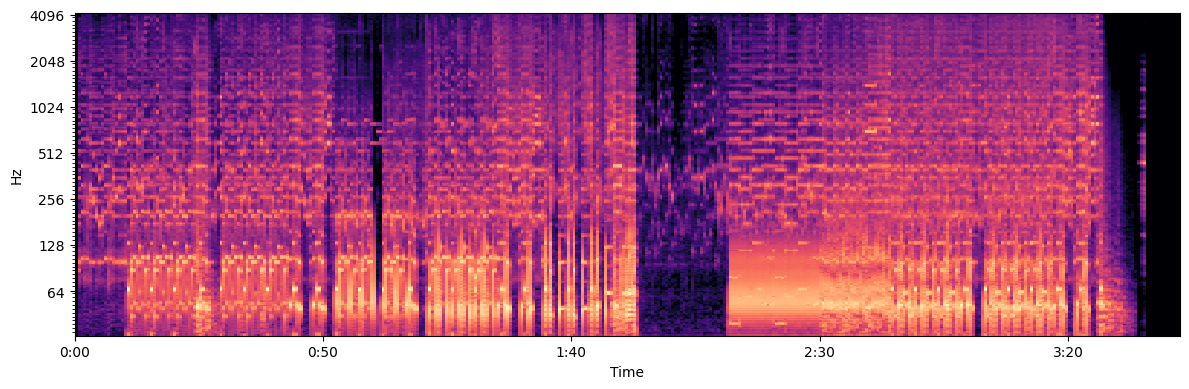

In [50]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3,
                         y_axis='cqt_hz', x_axis='time',
                         x_coords=beat_times,
                         y_coords=y_coords
                         )
plt.tight_layout()

### Build weighted recurrence matrix
* width=3 prevents links within the same bar
* mode='affinity' implements S_rep [after Eq 8]

In [51]:
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)
          

In [52]:
check_matrix(R)

matrix dtype: float64
matrix shape: (371, 371)
Matrix is Hermitian


In [53]:
# Enhance diagonals with a median filter (Equation 2)
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
R_smoothed = df(R, size=(1, 7))

In [54]:
check_matrix(R_smoothed)

matrix dtype: float64
matrix shape: (371, 371)
Matrix is NOT Hermitian


In [55]:
Rf = symmetrize_matrix(R_smoothed)

In [56]:
check_matrix(Rf)

matrix dtype: float64
matrix shape: (371, 371)
Matrix is Hermitian


### Build sequence matrix using mfcc-similarity

In [57]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
sigma = np.median(path_distance)
path_sim = np.exp(-path_distance / sigma)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [58]:
check_matrix(R_path)

matrix dtype: float32
matrix shape: (371, 371)
Matrix is Hermitian


#### Compute balanced combination matrix

In [59]:
deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

In [60]:
check_matrix(A)

matrix dtype: float64
matrix shape: (371, 371)
Matrix is Hermitian


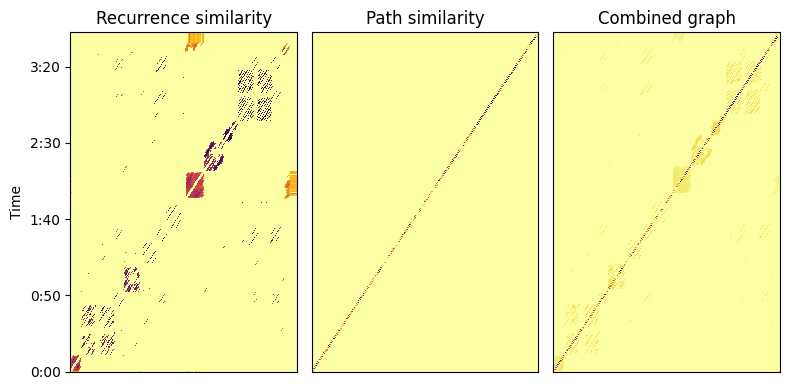

In [61]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(Rf, cmap='inferno_r', y_axis='time',
                         x_coords=beat_times,
                         y_coords=beat_times)
plt.title('Recurrence similarity')
plt.subplot(1, 3, 2)
librosa.display.specshow(R_path, cmap='inferno_r')
plt.title('Path similarity')
plt.subplot(1, 3, 3)
librosa.display.specshow(A, cmap='inferno_r')
plt.title('Combined graph')
plt.tight_layout()

### Compute normalized Laplacian

In [62]:
L = scipy.sparse.csgraph.laplacian(A, normed=True)

In [63]:
check_matrix(L)

matrix dtype: float64
matrix shape: (371, 371)
Matrix is Hermitian


In [64]:
try:
    L = L.astype(float)
except ValueError:
    print("Matrix contains non-numeric values that cannot be converted to float.")

In [65]:
# spectral decomposition; to avoid getting complex eigenvectors, use eigh()
evals, evecs = scipy.linalg.eigh(L)

In [66]:
print(evals.dtype, evecs.dtype)

float64 float64


In [67]:
print(evals.shape, evecs.shape)

(371,) (371, 371)


In [68]:
# We can clean this up further with a median filter.
# This can help smooth over small discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))


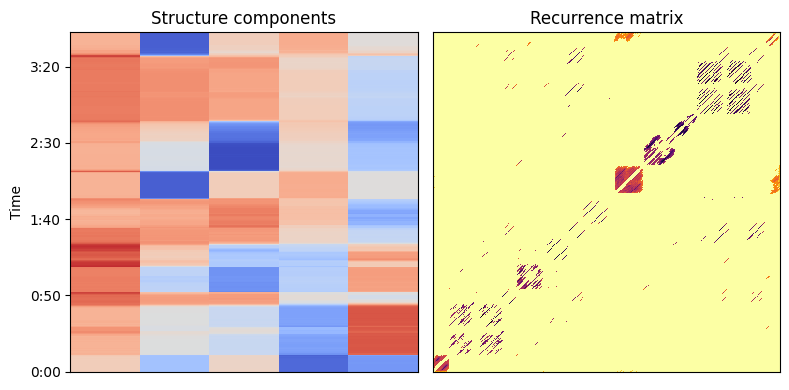

In [69]:
# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how the segmentation changes as you vary k

k = 5

X = evecs[:, :k] / Cnorm[:, k-1:k]


# Plot the resulting representation (Figure 1, center and right)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
librosa.display.specshow(Rf, cmap='inferno_r')
plt.title('Recurrence matrix')

plt.subplot(1, 2, 1)
librosa.display.specshow(X,
                         y_axis='time',
                         x_coords=range(0,k+1),
                         y_coords=beat_times)
plt.title('Structure components')
plt.tight_layout()

## Debug seg fault when call eig()

# free up large numpy arrays and matrices

del y
del C
del Csync
del beat_times
del y_coords
del R
del Rf
del R_path
del A

import gc
gc.collect()

In [72]:
# test eig()

import numpy as np
import scipy
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set to your desired number of threads
os.environ["OMP_NUM_THREADS"] = "1" # it is also good practice to set this.

n=500
r=np.random.random((n,n))

w,v=scipy.linalg.eig(r)

In [73]:
print("SciPy version:", scipy.__version__)
print("NumPy version:", np.__version__)

print("\nSciPy configuration:")
scipy.show_config()

print("\nNumPy configuration:")
np.show_config()

SciPy version: 1.15.2
NumPy version: 2.1.3

SciPy configuration:
Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas32/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas32/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.28 DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=64
    pc file directory: /project
    version: 0.3.28
  lapack:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas32/include
    lib directory: /opt/_internal/cpython-3.12.7/lib/python3.12/site-packages/scipy_openblas32/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.28 DYNAMIC_ARCH NO_AFFINITY Haswell MAX_THREADS=64
    pc file directory: /project
    version: 0.3.28
  pybind11:
    detection method: config-tool
    i